https://www.frontiersin.org/journals/public-health/articles/10.3389/fpubh.2022.834032/full

In [ ]:
#now we will not numpy, we will user tensor
#different data structure
import numpy as np
import tensorflow as tf

#backend of keras
#dataset imported
from tensorflow.keras import Model, layers
from tensorflow.keras.applications import ResNet50

#keras and the layers which are fully connected (Dense), Dropout, Flatten (convert all in vector automatic way), Conv2D and MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Add, SeparableConv2D

#to load a local dataset
import pathlib

In [ ]:
# data_dir = tf.keras.utils.get_file('Machine Learning', origin=data_path, untar = True)
data = "drive/My Drive/Sized Alzheimer Dataset"
data_dir = pathlib.Path(data)

In [ ]:
from google.colab import drive

# Monta Google Drive
drive.mount('/content/drive')

def scrivi_e_copia(file_path, contenuto):
    # Scrive nel file in modalità append
    with open(file_path, 'a') as file:
        file.write(contenuto)

    # Copia il file su Google Drive
    try:
        import shutil
        shutil.copy(file_path, 'drive/My Drive')
        print("File copiato con successo su Google Drive!")
    except Exception as e:
        print("Si è verificato un errore durante la copia del file su Google Drive:")

Mounted at /content/drive


In [ ]:
%%script true
from shutil import rmtree
from os.path import exists

# Specify the path of the directory to be deleted
directory_path = "./" + data

# Check if the directory exists before attempting to delete it
if exists(directory_path):
    rmtree(directory_path)
    print(f"The directory {directory_path} has been deleted.")
else:
    print(f"The directory {directory_path} does not exist.")

In [ ]:
%%script true
!pip3 install py7zr
from py7zr import SevenZipFile

with SevenZipFile(data + ".7z", mode='r') as z:
    z.extractall(path=directory_path)

In [ ]:
# counting the element
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

46322


In [ ]:
# defining the batch size and the dimension of photo
batch_size = 32
img_height = 128
img_width = 128

A **batch** is a set of samples used in one iteration of model training. In machine learning, especially in deep learning, data is often divided into batches to improve computational efficiency. Instead of updating the model's parameters after processing each individual sample, batches allow the model to update its parameters after processing multiple samples at once. This helps to speed up the training process and make better use of computational resources

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 46322 files belonging to 4 classes.
Using 34742 files for training.


In [ ]:
val_test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 46322 files belonging to 4 classes.
Using 11580 files for validation.


In [ ]:
num_val = int(0.4 * val_test_ds.cardinality().numpy())

# Split validation dataset into two parts: validation and test (10% test and 15% validation -> test 40% of validation)
val_ds = val_test_ds.take(num_val)
test_ds = val_test_ds.skip(num_val)

In [ ]:
class_names = train_ds.class_names
print(class_names)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


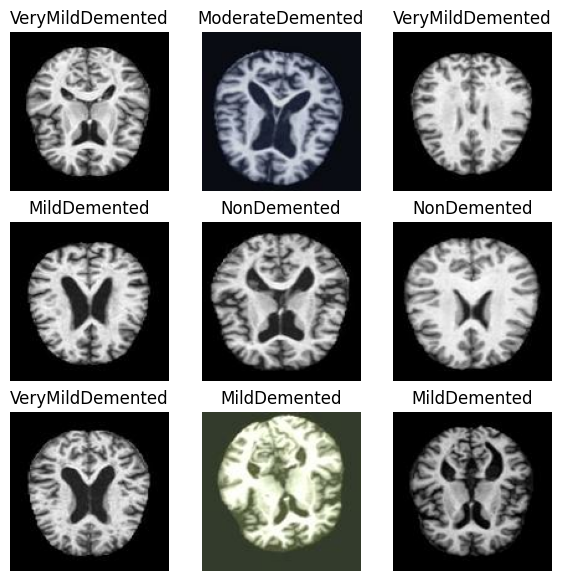

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Data Augmentation

In [ ]:
rescale = tf.keras.Sequential([
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2, "nearest"),
    layers.RandomZoom(0.15, 0.15, "nearest")
])

data_augmentation1 = tf.keras.Sequential([
    layers.RandomRotation(0.2, "nearest")
])

data_augmentation2 = tf.keras.Sequential([
    layers.RandomZoom(0.15, 0.15, "nearest")
])

data_augmentation3 = tf.keras.Sequential([
    layers.RandomTranslation(0.15, 0.15, "nearest")
])

def prepare(image, train = True, mode = 2):
    if mode == 0:
      return data_augmentation(rescale(image), training = train)

    if mode == 1:
      return rescale(image)

    val = np.random.randint(3)
    if val == 0:
      return data_augmentation1(rescale(image), training = train)
    elif val == 1:
      return data_augmentation2(rescale(image), training = train)
    return data_augmentation3(rescale(image), training = train)

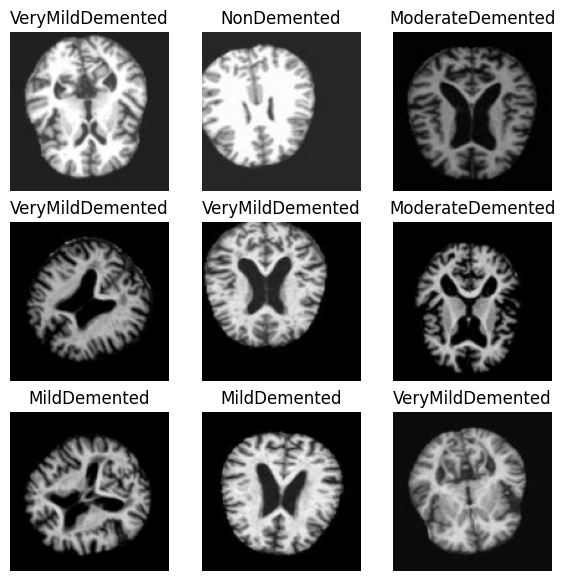

In [ ]:
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(prepare(images[i]))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
aug_train_ds = train_ds.map(lambda x, y: (prepare(x), y), num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Original
class CustomNN(Model):
    def __init__(self):
        super(CustomNN, self).__init__()
        # Definizione dei layer
        self.conv1 = Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1))
         # The first convolutional layer with 16 filters, 3x3 kernel size, ReLU activation, and same padding
        self.pool1 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.pool2 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv3 = Conv2D(64, (3, 3), activation='relu', strides=(2, 2))
        self.flatten = Flatten()
        self.fc1 = Dense(512, activation='relu')
        self.fc2 = Dense(4, activation='softmax') # The second fully connected layer with softmax activation (for classification)

    def call(self, x):
         # Defining the input flow through the layers
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    # from papar: https://www.frontiersin.org/journals/public-health/articles/10.3389/fpubh.2022.834032/full
    # NN di riferimento
    # Layers                  Kernel size/stride       Size
    #Imge size                                         160 x 160 x 1
    #Convolution L(C1)        3 x 3/1                  158 x 158 x 16
    #Polling Layer 1 (P1)     2 x 2/2                  79 x 79 x 16
    #Convolution L(C2)        3 x 3/1                  39 x 39 x 32
    #Polling Layer 1 (P1)     2 x 2/2                  20 x 20 x 32
    #Convolution L(C3)        3 x 3/2                  10 x 10 x 64
    #Flatten                                           6400
    #Fully connected Layer    512                      512
    #Soft Max                 2                        2

In [ ]:
# Original, added another convolutional layer
class CustomNN1(Model):
    def __init__(self):
        super(CustomNN1, self).__init__()
        # Definizione dei layer
        self.conv1 = Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1))
         # The first convolutional layer with 16 filters, 3x3 kernel size, ReLU activation, and same padding
        self.pool1 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.pool2 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.pool3 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv4 = Conv2D(128, (3, 3), activation='relu', strides=(2, 2))
        self.flatten = Flatten()
        self.fc1 = Dense(512, activation='relu')
        self.fc2 = Dense(4, activation='softmax') # The second fully connected layer with softmax activation (for classification)

    def call(self, x):
         # Defining the input flow through the layers
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    # from papar: https://www.frontiersin.org/journals/public-health/articles/10.3389/fpubh.2022.834032/full
    # NN di riferimento
    # Layers                  Kernel size/stride       Size
    #Imge size                                         160 x 160 x 1
    #Convolution L(C1)        3 x 3/1                  158 x 158 x 16
    #Polling Layer 1 (P1)     2 x 2/2                  79 x 79 x 16
    #Convolution L(C2)        3 x 3/1                  39 x 39 x 32
    #Polling Layer 1 (P1)     2 x 2/2                  20 x 20 x 32
    #Convolution L(C3)        3 x 3/2                  10 x 10 x 64
    #Flatten                                           6400
    #Fully connected Layer    512                      512
    #Soft Max                 2                        2

In [ ]:
# Second Paper
class CustomNN2(Model):
    def __init__(self):
        super(CustomNN2, self).__init__()
        # Definizione dei layer
        self.conv1 = Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1))
         # The first convolutional layer with 16 filters, 3x3 kernel size, ReLU activation, and same padding
        self.pool1 = MaxPooling2D((4, 4), strides=(2, 2))
        self.conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')
        self.pool2 = MaxPooling2D((3, 3), strides=(2, 2))
        self.conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.pool3 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv4 = Conv2D(64, (3, 3), activation='relu', strides=(2, 2))
        self.pool4 = MaxPooling2D((2, 2), strides=(2, 2))
        self.flatten = Flatten()
        self.fc1 = Dense(256, activation='relu')
        self.fc2 = Dense(4, activation='softmax') # The second fully connected layer with softmax activation (for classification)

    def call(self, x):
         # Defining the input flow through the layers
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    # from papar: https://www.frontiersin.org/journals/public-health/articles/10.3389/fpubh.2022.834032/full
    # NN di riferimento
    # Layers                  Kernel size/stride       Size
    #Imge size                                         160 x 160 x 1
    #Convolution L(C1)        3 x 3/1                  158 x 158 x 16
    #Polling Layer 1 (P1)     2 x 2/2                  79 x 79 x 16
    #Convolution L(C2)        3 x 3/1                  39 x 39 x 32
    #Polling Layer 1 (P1)     2 x 2/2                  20 x 20 x 32
    #Convolution L(C3)        3 x 3/2                  10 x 10 x 64
    #Flatten                                           6400
    #Fully connected Layer    512                      512
    #Soft Max                 2                        2

In [ ]:
# Original, removed a convolutional layer
class CustomNN3(Model):
    def __init__(self):
        super(CustomNN3, self).__init__()
        # Definizione dei layer
        self.conv1 = Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1))
         # The first convolutional layer with 16 filters, 3x3 kernel size, ReLU activation, and same padding
        self.pool1 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.pool2 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv3 = Conv2D(64, (3, 3), activation='relu', strides=(2, 2))
        self.flatten = Flatten()
        self.fc1 = Dense(512, activation='relu')
        self.fc2 = Dense(4, activation='softmax') # The second fully connected layer with softmax activation (for classification)

    def call(self, x):
         # Defining the input flow through the layers
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    # from papar: https://www.frontiersin.org/journals/public-health/articles/10.3389/fpubh.2022.834032/full
    # NN di riferimento
    # Layers                  Kernel size/stride       Size
    #Imge size                                         160 x 160 x 1
    #Convolution L(C1)        3 x 3/1                  158 x 158 x 16
    #Polling Layer 1 (P1)     2 x 2/2                  79 x 79 x 16
    #Convolution L(C2)        3 x 3/1                  39 x 39 x 32
    #Polling Layer 1 (P1)     2 x 2/2                  20 x 20 x 32
    #Convolution L(C3)        3 x 3/2                  10 x 10 x 64
    #Flatten                                           6400
    #Fully connected Layer    512                      512
    #Soft Max                 2                        2

In [ ]:
# Second paper with 8 CVL
class CustomNN4(Model):
    def __init__(self):
        super(CustomNN4, self).__init__()
        # Definizione dei layer
        self.conv1 = Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1))
        self.conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')
        self.pool1 = MaxPooling2D((4, 4), strides=(2, 2))
        self.conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')
        self.conv4 = Conv2D(16, (3, 3), activation='relu', padding='same')
        self.pool2 = MaxPooling2D((3, 3), strides=(2, 2))
        self.conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.pool3 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.conv8 = Conv2D(64, (3, 3), activation='relu', strides=(2, 2))
        self.pool4 = MaxPooling2D((2, 2), strides=(2, 2))
        self.flatten = Flatten()
        self.fc1 = Dense(256, activation='relu')
        self.fc2 = Dense(4, activation='softmax') # The second fully connected layer with softmax activation (for classification)

    def call(self, x):
         # Defining the input flow through the layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.pool3(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.pool4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    # from papar: https://www.frontiersin.org/journals/public-health/articles/10.3389/fpubh.2022.834032/full
    # NN di riferimento
    # Layers                  Kernel size/stride       Size
    #Imge size                                         160 x 160 x 1
    #Convolution L(C1)        3 x 3/1                  158 x 158 x 16
    #Polling Layer 1 (P1)     2 x 2/2                  79 x 79 x 16
    #Convolution L(C2)        3 x 3/1                  39 x 39 x 32
    #Polling Layer 1 (P1)     2 x 2/2                  20 x 20 x 32
    #Convolution L(C3)        3 x 3/2                  10 x 10 x 64
    #Flatten                                           6400
    #Fully connected Layer    512                      512
    #Soft Max                 2                        2

In [ ]:
# Martin version 1
class CustomNN5(Model):
    def __init__(self):
        super(CustomNN5, self).__init__()
        self.conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1))
        self.pool1 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.pool2 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv3 = Conv2D(128, (3, 3), activation='relu', strides=(2, 2))
        self.pool3 = MaxPooling2D((2, 2), strides=(2, 2))
        # Adding a global average pooling layer to reduce the dimensions instead of flattening
        self.global_pool = GlobalAveragePooling2D()
        self.fc1 = Dense(128, activation='relu')
        self.fc2 = Dense(4, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.global_pool(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [ ]:
# Sam version
class CustomNN6(Model):
    def __init__(self):
        super(CustomNN6, self).__init__()
        self.conv1 = Conv2D(4, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1))
        self.pool1 = MaxPooling2D((3, 3), strides=(2, 2))
        self.conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')
        self.pool2 = MaxPooling2D((3, 3), strides=(2, 2))
        self.conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')
        self.pool3 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.pool4 = MaxPooling2D((2, 2), strides=(2, 2))
        self.flatten = Flatten()
        self.bn = BatchNormalization()
        self.fc1 = Dense(256, activation='leaky_relu')
        self.drop1 = Dropout(0.45) # Drop some nodes during training (prevents overfitting)
        self.fc2 = Dense(8, activation='relu')
        self.drop2 = Dropout(0.4) # Drop some nodes during training (prevents overfitting)
        self.fc3 = Dense(4, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.flatten(x)
        x = self.bn(x)
        x = self.fc1(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        x = self.fc3(x)
        return x

In [ ]:
# Martin version 2
class CustomNN7(Model):
    def __init__(self):
        super(CustomNN7, self).__init__()
        self.conv1 = Conv2D(16, (3, 3), padding='same', input_shape=(128, 128, 1))
        self.bn1 = BatchNormalization()
        self.pool1 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv2 = Conv2D(32, (3, 3), padding='same')
        self.bn2 = BatchNormalization()
        self.pool2 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv3 = Conv2D(64, (3, 3), strides=(2, 2))
        self.bn3 = BatchNormalization()
        self.flatten = Flatten()
        self.fc1 = Dense(512, activation='relu')
        self.dropout = Dropout(0.5)
        self.fc2 = Dense(4, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Martin version 3 (Separable Convolutional Layers)
class CustomNN8(Model):
    def __init__(self):
        super(CustomNN8, self).__init__()
        self.conv1 = SeparableConv2D(32, (3, 3), padding='same', input_shape=(128, 128, 1))
        self.bn1 = BatchNormalization()
        self.pool1 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv2 = SeparableConv2D(64, (3, 3), padding='same')
        self.bn2 = BatchNormalization()
        self.pool2 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv3 = SeparableConv2D(128, (3, 3), strides=(2, 2))
        self.bn3 = BatchNormalization()
        self.pool3 = MaxPooling2D((2, 2), strides=(2, 2))
        self.flatten = Flatten()
        self.fc1 = Dense(256, activation='relu')
        self.dropout = Dropout(0.5)
        self.fc2 = Dense(4, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Martin version 4 (Global Average Pooling)
class CustomNN9(Model):
    def __init__(self):
        super(CustomNN9, self).__init__()
        self.conv1 = Conv2D(32, (3, 3), padding='same', input_shape=(128, 128, 1))
        self.conv2 = Conv2D(32, (3, 3), padding='same')
        self.pool1 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv3 = Conv2D(64, (3, 3), padding='same')
        self.conv4 = Conv2D(64, (3, 3), padding='same')
        self.pool2 = MaxPooling2D((2, 2), strides=(2, 2))
        self.global_pool = GlobalAveragePooling2D()
        self.fc1 = Dense(128, activation='relu')
        self.dropout = Dropout(0.5)
        self.fc2 = Dense(4, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.global_pool(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Martin version 5 (Residual Connections)
class CustomNN10(Model):
    def __init__(self):
        super(CustomNN10, self).__init__()
        self.conv1 = Conv2D(32, (3, 3), padding='same', input_shape=(128, 128, 1))
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(32, (3, 3), padding='same')
        self.bn2 = BatchNormalization()
        self.add = Add()
        self.pool1 = MaxPooling2D((2, 2), strides=(2, 2))
        self.conv3 = Conv2D(64, (3, 3), padding='same')
        self.bn3 = BatchNormalization()
        self.conv4 = Conv2D(64, (3, 3), padding='same')
        self.bn4 = BatchNormalization()
        #self.add2 = Add()
        self.global_pool = GlobalAveragePooling2D()
        self.fc1 = Dense(128, activation='relu')
        self.dropout = Dropout(0.5)
        self.fc2 = Dense(4, activation='softmax')

    def call(self, x):
        x_copy = x
        x = self.conv1(x)
        x = self.bn1(x)
        x_copy = self.conv2(x_copy)
        x_copy = self.bn2(x_copy)
        x = self.add([x, x_copy])
        x_copy = x = self.pool1(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x_copy = self.conv4(x_copy)
        x_copy = self.bn4(x_copy)
        x = self.add([x, x_copy])
        x = self.global_pool(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# CustomNN11 (ResNet50)
resnet50 = ResNet50(weights='imagenet',
                    input_shape=(128, 128, 3), # 3 channels because of imagenet
                    include_top=False)

def CustomNN11():
    x = GlobalAveragePooling2D()(resnet50.output)
    output = Dense(4, activation='softmax')(x)

    return Model(inputs=resnet50.input, outputs=output)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
class CustomNN12(tf.keras.Model):
    def __init__(self, models):
        super(CustomNN12, self).__init__()
        self.models = models

    def call(self, inputs):
        predictions = [model.predict(inputs) for model in self.models]
        # Compute the majority vote
        ensemble_pred = np.argmax(np.sum(predictions, axis=0), axis=1)
        return ensemble_pred

**Convolutional Neural Network (CNN):**

A Convolutional Neural Network (CNN) is a type of artificial neural network commonly used for image classification, object detection, and other tasks related to computer vision. CNNs are designed to automatically and adaptively learn spatial hierarchies of features from input images. They consist of multiple layers, including convolutional layers, pooling layers, and fully connected layers. CNNs have revolutionized the field of computer vision and are widely used in various applications, including image recognition, medical image analysis, and autonomous driving.

**Fully Connected Layer:**


A fully connected layer, also known as a dense layer, is a type of layer in a neural network where each neuron is connected to every neuron in the previous layer. In a fully connected layer, each neuron receives input from all the neurons in the previous layer and produces an output that is passed to all the neurons in the next layer. Fully connected layers are typically used in the later stages of a neural network to perform classification or regression tasks based on the learned features.

**Dropout:**


Dropout is a regularization technique used in neural networks to prevent overfitting. During training, dropout randomly disables a fraction of neurons in the network, forcing the network to learn redundant representations of the data. This helps to prevent the network from relying too heavily on any one feature, making it more robust and generalizable. Dropout is applied during training but not during inference, where all neurons are used.

**Flatten Layer:**


A flatten layer is a type of layer in a neural network that is used to convert multidimensional input data into a one-dimensional array. This is often necessary when transitioning from convolutional layers, which operate on multidimensional data such as images, to fully connected layers, which require one-dimensional input. The flatten layer reshapes the input data without changing its content, allowing it to be processed by the fully connected layers.

**optimizer**='*adam*':

Adam is an optimization algorithm that is commonly used for training neural networks. It dynamically adjusts the learning rate during training, which can lead to faster convergence and better performance.


**loss**='*sparse_categorical_crossentropy*':

This specifies the loss function used during training. Cross-entropy loss is often used for classification problems. In this case, 'sparse_categorical_crossentropy' is used because the labels are integers (not one-hot encoded). This loss function calculates the difference between the predicted probabilities and the true labels.


**metrics**=['*accuracy*']:

During training, it's useful to monitor certain metrics to evaluate the performance of the model. 'accuracy' is a common metric for classification problems, which measures the proportion of correctly classified examples.

An **epoch** is a complete pass through the entire dataset during the training process. In other words, it represents one cycle of training where the model sees and learns from all the training examples. During each epoch, the model's parameters are adjusted multiple times as it processes batches of data. Training typically involves running multiple epochs to allow the model to learn from the data more effectively.

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
def printPlot(epochs, acc, val_acc, loss, val_loss):
    epochs_range = range(epochs)

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

Best Models:
- M4: 2, 1
- M2: 3, 3
- M1: 1, 4
- M: 7, 2
- M3: 6, 5
- M5: 4, ...
- M7: 5, ...

In [ ]:
# dont't execute this part
%%script true

epochs=10

models = [CustomNN(), CustomNN1(), CustomNN2(), CustomNN3(), CustomNN4(), CustomNN5(), CustomNN7()]

aug_train_ds = train_ds.map(lambda x, y: (prepare(x, True, 0), y), num_parallel_calls=tf.data.AUTOTUNE)

for i in range(len(models)):
    # Compile the Model
    models[i].compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    # Train the Model
    history = models[i].fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=epochs
    )

    # Print Graph Results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    #printPlot(epochs, acc, val_acc, loss, val_loss)

    test_results = models[i].evaluate(test_ds)

    # Print Numerical values in the output file
    with open("HypTuning - Complex Aug.txt", "a") as txt_file:
        txt_file.write(str(acc) + " " + str(val_acc) + " " + str(loss) +
                       str(val_loss) + " " + str(test_results[0]) + " " +  str(test_results[1]) + "\n")

In [ ]:
# dont't execute this part
%%script true

epochs=20

models = [CustomNN(), CustomNN1(), CustomNN2(), CustomNN3(), CustomNN4(), CustomNN5(), CustomNN7()]

aug_train_ds = train_ds.map(lambda x, y: (prepare(x), y), num_parallel_calls=tf.data.AUTOTUNE)

for i in range(len(models)):
    # Compile the Model
    models[i].compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    # Train the Model
    history = models[i].fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=epochs
    )

    # Print Graph Results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    #printPlot(epochs, acc, val_acc, loss, val_loss)

    test_results = models[i].evaluate(test_ds)

    # Print Numerical values in the output file
    with open("HypTuning - More Epochs.txt", "a") as txt_file:
        txt_file.write(str(acc) + " " + str(val_acc) + " " + str(loss) +
                       str(val_loss) + " " + str(test_results[0]) + " " +  str(test_results[1]) + "\n")

In [ ]:
def opt_switch(argument):
    switcher = {
        "Adadelta": tf.keras.optimizers.Adadelta(),
        "Adafactor": tf.keras.optimizers.Adafactor(),
        "AdamW": tf.keras.optimizers.AdamW(),
        "Lion": tf.keras.optimizers.Lion(),
        "Nadam": tf.keras.optimizers.Nadam(),
        "RMSprop": tf.keras.optimizers.RMSprop(),
        "SGD": tf.keras.optimizers.SGD()
    }
    return switcher.get(argument, "Scelta non valida")

In [ ]:
epochs=10

models = [CustomNN4()]

optimizersStr = ["SGD"]

#aug_train_ds = train_ds.map(lambda x, y: (prepare(x), y), num_parallel_calls=tf.data.AUTOTUNE)

for optString in optimizersStr:
    for i in range(len(models)):

        # Compile the Model
        models[i].compile(optimizer=opt_switch(optString),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

        # Train the Model
        history = models[i].fit(
            aug_train_ds,
            validation_data=val_ds,
            epochs=epochs
        )

        # Print Graph Results
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        loss = history.history['loss']
        val_loss = history.history['val_loss']

        #printPlot(epochs, acc, val_acc, loss, val_loss)

        test_results = models[i].evaluate(test_ds)

        # Print Numerical values in the output file
        scrivi_e_copia("HypTuning - Opt.txt", "- " + optString + "\n" + str(acc) + " " + str(val_acc) + " " + str(loss) +
                          str(val_loss) + " " + str(test_results[0]) + " " +  str(test_results[1]) + "\n")
    print(f"{optString} Done")

Epoch 1/10
1086/1086 [==============================] - 889s 817ms/step - loss: 1.3361 - accuracy: 0.3450 - val_loss: 13.6340 - val_accuracy: 0.3377
Epoch 2/10
1086/1086 [==============================] - 892s 820ms/step - loss: 1.3075 - accuracy: 0.3680 - val_loss: 126.0516 - val_accuracy: 0.3375
Epoch 3/10
1086/1086 [==============================] - 886s 815ms/step - loss: 1.2320 - accuracy: 0.4113 - val_loss: 49.8855 - val_accuracy: 0.4779
Epoch 4/10
1086/1086 [==============================] - 885s 814ms/step - loss: 1.1105 - accuracy: 0.4736 - val_loss: 122.4789 - val_accuracy: 0.4905
Epoch 5/10
1086/1086 [==============================] - 884s 812ms/step - loss: 0.9711 - accuracy: 0.5381 - val_loss: 73.8000 - val_accuracy: 0.5684
Epoch 6/10
1086/1086 [==============================] - 891s 820ms/step - loss: 0.8924 - accuracy: 0.5720 - val_loss: 133.6255 - val_accuracy: 0.4952
Epoch 7/10
1086/1086 [==============================] - 887s 816ms/step - loss: 0.8411 - accuracy: 0.59

In [ ]:
# dont't execute this part
%%script true

epochs=10

models = [CustomNN(), CustomNN1(), CustomNN2(), CustomNN3(), CustomNN4(), CustomNN5(), CustomNN7()]

optimizers = ["Adadelta", "Adafactor", "AdamW", "Lion", "Nadam", "RMSprop", "SGD"]

#aug_train_ds = train_ds.map(lambda x, y: (prepare(x), y), num_parallel_calls=tf.data.AUTOTUNE)

for opt in optimizers:
    for i in range(len(models)):
        # Compile the Model
        models[i].compile(optimizer=opt,
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

        # Train the Model
        history = models[i].fit(
            aug_train_ds,
            validation_data=val_ds,
            epochs=epochs
        )

        # Print Graph Results
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        loss = history.history['loss']
        val_loss = history.history['val_loss']

        #printPlot(epochs, acc, val_acc, loss, val_loss)

        test_results = models[i].evaluate(test_ds)

        # Print Numerical values in the output file
        with open("HypTuning - Opt.txt", "a") as txt_file:
            txt_file.write("- " + opt + "\n" + str(acc) + " " + str(val_acc) + " " + str(loss) +
                          str(val_loss) + " " + str(test_results[0]) + " " +  str(test_results[1]) + "\n")

In [ ]:
# dont't execute this part
%%script true

# Custom class to create a confusion matrix with sklearn
from sklearn.metrics import plot_confusion_matrix

class estimator:
  _estimator_type = ''
  classes_=[]
  def init(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

classifier = estimator(model, train_ds.class_names)
test_data = model.predict(test_dataset)
test_label = np.concatenate([y for _, y in train_ds], axis=0)
plot_confusion_matrix(estimator=classifier, X=test_data, y_true=test_labels, cmap='Blues', normalize='true', ax=plt.subplots(figsize=(12,12))[1])